<h1 style=“font-size:5rem;color:orange;“> PHOTON SEEDING: Number of first pairs</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import h5py
import matplotlib as mpl
warnings.filterwarnings("ignore", category=RuntimeWarning)
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams["mathtext.fontset"] = "cm"
pi = np.pi
W_0=3.776837598996484e+18

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


I) Interpolation of the tables.

Note that the arguments X or Y correspond to the log10 of the quantum parameter

In [2]:
class table1D(object):
    def __init__(self, xmin, xmax, table):
        self.xmin = xmin
        self.xmax = xmax
        self.Nx = table.shape[0]
        self.Table = table
    
    def interpolate(self, X):
        Di = (X-self.xmin)/(self.xmax-self.xmin)*(self.Nx-1)
        I = Di.astype('i')
        Di -= I
        keep = (0<=I)*(I<self.Nx-1)
        result = np.empty_like(X)
        result[~keep] = 0.
        result[keep] = (
            (1.-Di[keep])*self.Table[I[keep]]
            +(Di[keep])*self.Table[I[keep]+1]
        )
        return result
    
class table2D(object):
    def __init__(self, xmin, xmax, ymin, ymax, table):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.Nx= table.shape[0]
        self.Ny= table.shape[1]
        self.Table = table
    
    def interpolate(self, X,Y):
        Di = (X-self.xmin)/(self.xmax-self.xmin)*(self.Nx-1)
        I = Di.astype('i')
        Di -= I
        Dj = (Y-self.ymin)/(self.ymax-self.ymin)*(self.Ny-1)
        J = Dj.astype('i')
        Dj -= J
        keep = (0<=I)*(0<=J)*(I<self.Nx-1)*(J<self.Ny-1)
        result = np.empty_like(X)
        result[~keep] = 0.
        result[keep] = (
            (1.-Di[keep])*(1.-Dj[keep])*self.Table[I[keep],J[keep]]
            +(Di[keep])*(1.-Dj[keep])*self.Table[I[keep]+1,J[keep]]
            +(1.-Di[keep])*(Dj[keep])*self.Table[I[keep],J[keep]+1]
            +(Di[keep])*(Dj[keep])*self.Table[I[keep]+1,J[keep]+1]
        )
        return result 

II) Load tables for non-linear Compton scattering (NCS) and non-linear Breit-Wheeler (NBW) processes

In [3]:
# Tabulated "F?" function for the NCS rate
#   shape: 1024x1024
#   axes: chi,chi_gamma
#   extent: [1e-3,1e3], [1e-3,1e3] (log10space)
with h5py.File('TABLES/W_ncs_el_ph_L.h5', 'r') as hf:
    Wncs_el_ph = table2D(-3,3,-3,3,hf['WnCSG'][()])

# Tabulated "G?" function for the NBW rate
#   shape: 1024x1024
#   axes: chi_gamma,chi
#   extent: [1e-3,1e3], [1e-3,1e3] (log10space)
with h5py.File('TABLES/W_bw_ph_el_L.h5', 'r') as hf:
    Wbw_ph_el = table2D(-3,3,-3,3,hf['WBWE'][()].T)

# Tabulated "A?" function for the NCS rate
#   shape: 1024
#   axes: chi
#   extent: [1e-3,1e3] (log10space)
with h5py.File('TABLES/W_ncs_el_L.h5', 'r') as hf:
    Wncs_el = table1D(-3,3,hf['WnCS'][()])

# Tabulated "B?" function for the NBW rate
#   shape: 1024
#   axes: chi_gamma
#   extent: [1e-3,1e3] (log10space)
with h5py.File('TABLES/W_bw_ph_L.h5', 'r') as hf:
    Wbw_ph = table1D(-3,3,hf['WBW'][()])

III) Definition of the geometry

Here, linearly-polarized laser and counter propagation

In [4]:
def laser(t_minus_x,tfwhm):
    #Laser field definition: Linearly polarized
    return np.sin(2*pi*t_minus_x)*np.sin(pi/2.*t_minus_x/tfwhm)*np.heaviside(t_minus_x,0.)*np.heaviside(2*tfwhm-t_minus_x,0.)

def compute_quantum_parameter(gamma,a_0,a_s,t,tfwhm):
    #Quantum parameter for linear polarized laser in counter propagation with incident beam
    #t_minus_x=t-x/c=2t
    return 2.*gamma*a_0/a_s*np.abs(laser(2.*t,tfwhm))

IV) Solve average energy evolution of initial lepton

$\frac{d}{dt}\langle\gamma\rangle= -W_0\,\langle\chi\rangle^2(t)\,g\!\left(\langle\chi\rangle(t)\right)$

Complexity $O(N_t)$

In [5]:
def g(chi):
    #Gaunt factor
    return (1.+4.8*(1.+chi)*np.log(1.+1.7*chi)+2.44*chi**2)**(-2/3.)

def compute_average_energy(gamma_0,a_0,a_s,omega,Times,dT,tfwhm):
    #Average energy of the incident leptons in time
    avg_gamma = np.zeros(len(Times))
    avg_gamma[0] = gamma_0
    Nt = len(Times)
    #Calculate the average energy in time
    for i in range (Nt-1):
        #Quantum parameter of the leptons
        avg_chi = compute_quantum_parameter(avg_gamma[i],a_0,a_s,Times[i],tfwhm)
        #Quantum parameter of the incident photon
        avg_gamma[i+1]=avg_gamma[i]-W_0*avg_chi**2*g(avg_chi)*dT[i]*2*pi/omega
    return avg_gamma

V) Compute the probability of a photon to decay between times t and T (`=Times[-1]`) for an array of values of t from 0 to T

$1-\exp{\left[-\int_t^T d\tau W_{nBW}(\gamma_\gamma,\chi_\gamma(\tau))\right]}$

In [6]:
def compute_probability_to_decay(gamma_gamma,a_0,a_s,omega,Times,dT,tfwhm):
    #Probability to decay if photon at gamma_gamma interact with the laser between t to the last time
    #Quantum parameter of photon in time
    chi_gamma = compute_quantum_parameter(gamma_gamma,a_0,a_s,Times,tfwhm)
    #Breit Wheeler rate in time 
    BW_rate = Wbw_ph.interpolate(np.log10(chi_gamma))/gamma_gamma
    #Integral of Breit Wheeler from t' to the last time
    BW_optical_depth = np.zeros(len(Times))
    BW_optical_depth[1:] = np.cumsum((BW_rate[1:]+BW_rate[:-1])/2.*dT*2*pi/omega)
    BW_optical_depth = BW_optical_depth[-1] - BW_optical_depth
    return 1.-np.exp(-BW_optical_depth)

VI) Compute the rate of photon emission by a lepton at the average energy

$w_{nCS}(\langle \gamma \rangle(t),\gamma_\gamma)$

In [7]:
def compute_emission_rate(gamma_gamma,avg_gamma,a_0,a_s,Times,tfwhm):
    #Average quantum parameter of the incident lepton
    avg_chi = compute_quantum_parameter(avg_gamma,a_0,a_s,Times,tfwhm)
    #Quantum parameter of the emitted photon
    chi_gamma = compute_quantum_parameter(gamma_gamma,a_0,a_s,Times,tfwhm)
    #Non linear Compton Scattering rate at average energy of first lepton
    return Wncs_el_ph.interpolate(np.log10(avg_chi)*np.ones(len(chi_gamma)),np.log10(chi_gamma))/avg_gamma/gamma_gamma

VII) Compute the number of first pairs at the end of the interaction T=Times[-1]

$N_\pm^{(1)}(T) = \int_0^\infty\!d\gamma_\gamma\int_0^T\!dt'\,w_{nCS}\!\left(\langle\gamma\rangle(t'),\gamma_\gamma\right)
    \,\left[1 - \exp\left(-\int_{t'}^T\!d\tau\,W_{nBW}(\gamma_\gamma,\chi_\gamma(\tau))\right)\right]
$

Complexity $O(N_t\times N_\gamma)$

In [8]:
def compute_N_pairs_1(gamma_0,a_0,a_s,omega,Gamma,Times,dT,tfwhm):
    #Number of second pairs at last time
    #Spectrum of photons which have decayed during the interaction
    Ng = len(Gamma)
    Ph_Decayed = np.zeros(Ng)
    #Average energy of the first leptons in time if created at gamma_0
    avg_gamma_0 = compute_average_energy(gamma_0,a_0,a_s,omega,Times,dT,tfwhm)
    #For each energy
    for i in range (Ng):
        #nCS rate to emit photon at Gamma[i] in time
        CS_rate = compute_emission_rate(Gamma[i],avg_gamma_0,a_0,a_s,Times,tfwhm)
        #Probability of a photon at Gamma[i] to decay before last time
        BW_probability = compute_probability_to_decay(Gamma[i],a_0,a_s,omega,Times,dT,tfwhm)
        #Photons of energy Gamma[i] which have decay before last time
        #Right integrale of Eq XX
        Ph_Decayed[i] = np.trapz(CS_rate*BW_probability,x=Times*2*pi/omega)
    #Integral of all the decayed photons or the number of second pairs at last time
    #Left integrale of Eq XX
    return np.trapz(Ph_Decayed,x=Gamma) 

IX) Compute the number of first pairs as a function of time

$N_\pm^{(1)}(t) = \int_0^\infty\!d\gamma_\gamma\int_0^t\!dt'\,\,w_{nCS}\!\left(\langle\gamma\rangle(t'),\gamma_\gamma\right)
    \,\left[1 - \exp\left(-\int_{t'}^t\!d\tau\,W_{nBW}(\gamma_\gamma,\chi_\gamma(\tau))\right)\right]
$


Calculation of the survivor photons emitted by the incident lepton:

$
\int_0^t\!dt'\,w_{nCS}(\langle\gamma\rangle(t'),\gamma_\gamma)\exp\left(-\int_{t'}^t\!d\tau\,W_{nBW}(\gamma_\gamma,\chi_\gamma(\tau))\right)\, .
$

and the spectrum of the photons that decayed to create the first pairs:

$
\int_0^t\!dt'\,w_{nCS}\!\left(\langle\gamma\rangle(t'),\gamma_\gamma\right)
    \,\left[1 - \exp\left(-\int_{t'}^t\!d\tau\,W_{nBW}(\gamma_\gamma,\chi_\gamma(\tau))\right)\right]
$

as function of time and energy

Complexity $O(N_t^2 \times N_\gamma)$

In [9]:
def compute_N_pairs_1_times(gamma_0,a_0,a_s,omega,Gamma,Times,dT,tfwhm):
    Nt = len(Times)
    Ng = len(Gamma)
    #Number of second pairs in function of time
    N_pairs_1 = np.zeros(Nt)
    #Average energy of the first leptons in time if created at gamma_0
    avg_gamma_0 = compute_average_energy(gamma_0,a_0,a_s,omega,Times,dT,tfwhm)
    #nBW rate in times and photons energy
    BW_rate = np.zeros((Nt,Ng))
    #nCS spectral rate at the leptons avergare energy and photons energy
    CS_rate = np.zeros((Nt,Ng))
    #Integral of Wbw from 0 to t for all photons energy
    BW_optical_depth = np.zeros((Nt,Ng))
    for i in range (Ng):
        #quantum parameter of photon at Gamma[i] in time
        chi_gamma = compute_quantum_parameter(Gamma[i],a_0,a_s,Times,tfwhm)
        CS_rate[:,i] = compute_emission_rate(Gamma[i],avg_gamma_0,a_0,a_s,Times,tfwhm)
        BW_rate[:,i] = Wbw_ph.interpolate(np.log10(chi_gamma))/Gamma[i]
        BW_optical_depth[1:,i] = np.cumsum((BW_rate[1:,i]+BW_rate[:-1,i])/2.*dT*2*pi/omega)
    #
    Ph_Decayed = np.zeros((Nt,Ng))
    Ph_Survivor = np.zeros((Nt,Ng))
    for i in range (1,Nt):
        Ph_Decayed[i,:] = np.trapz(CS_rate[:i,:]*(1.-np.exp(-BW_optical_depth[i,:]+BW_optical_depth[:i,:])),x=Times[:i]*2*pi/omega,axis=0)
        Ph_Survivor[i,:] = np.trapz(CS_rate[:i,:]*(np.exp(-BW_optical_depth[i,:]+BW_optical_depth[:i,:])),x=Times[:i]*2*pi/omega,axis=0)
        N_pairs_1[i] = np.trapz(Ph_Decayed[i,:],x=Gamma)
    return Ph_Decayed,Ph_Survivor,N_pairs_1


X) Definition of parameters

Note that the time is in unit of $\tau$ (the laser period)

In [10]:
lambd=0.8e-6 # laser wavelength
omega=2*pi*3e8/lambd #
tau=lambd/3e8
a_s=7.763440706293301e+20/omega
a_0=200.
gamma_0=1e4
tfwhm=7.5
Ng=512
Nt=1024
Gamma=np.logspace(np.log10(2),np.log10(gamma_0),Ng)
Times=np.linspace(0,tfwhm,Nt)
dT=np.diff(Times)

Calculation of the number of 1st and 2nd pairs at the end of interaction

In [11]:
N1th=compute_N_pairs_1(gamma_0,a_0,a_s,omega,Gamma,Times,dT,tfwhm)
print(f'Number of first pairs {N1th}')

Number of first pairs 2.392820808656853


Calculation of the number of pairs as function of time

In [12]:
PhDecayedth,PhSurvivorth,N1th=compute_N_pairs_1_times(gamma_0,a_0,a_s,omega,Gamma,Times,dT,tfwhm)

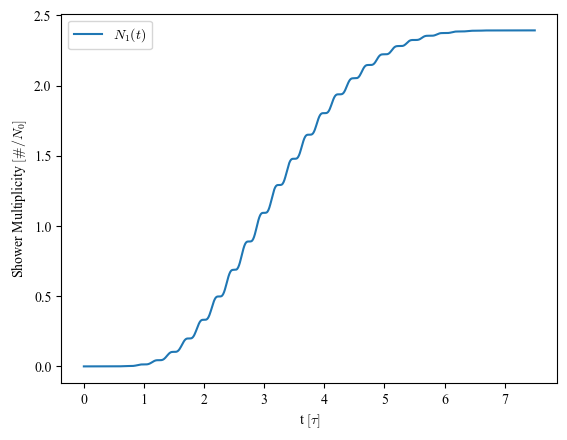

In [13]:
plt.plot(Times,N1th,label=r'$N_1(t)$')
plt.xlabel(r't $[\tau]$')
plt.ylabel(r'Shower Multiplicity $[\#/N_0]$')
plt.legend()
plt.show()